In [5]:
import numpy as np
import pandas as pd

import optuna

from prophet import Prophet
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split

# Plot
from prophet.plot import plot_plotly, plot_components_plotly
import matplotlib.pyplot as plt

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 9]

# 時系列線形予測を【結果】として何に使用するか？

・この予測モデルは、訓練を行い、【予測】を行う。これは予測という結果を求める

・予測を行えるモデルとは、新しいデータを与えた時に、そのデータが訓練データと一致する事を求める、つまりは、見たことの無いデータに対して精度の高い予測、つまり汎化を行う
　という事を目的としている。
 
・時系列の場合、これは新しいデータ、つまり日次を与えられた際に、その日時に一致した数値を出力(予測)する事が求められる。つまり未来を予測するという事。

・未来の予測の精度が下がっている場合、その修正として再度訓練を行い、修正する必要がある。

# Prophet

Facebook によると、Prophet はデフォルト設定で正確な予測結果を提供でき、調整はほとんどまたはまったく必要ありません。

【A.】予測が正確でない時には、これは元の訓練データ数が少なすぎるのが問題であるように思う。K-Fold交差検証などを使用して
　　　訓練データが少ない場合の対処を行う必要があるように思う。

Prophetは毎月のデータを自動的に検出し、毎週および毎日の季節性を無効にする。

【A.】つまり、SeasonalARIMAなどの季節性ARIMAを使用しなくてもよいという事。

【A.】たとえば、時系列の予測に対して、このような使い方を行う。

 　　　１か月先の予測では約 5% の誤差が典型的であり、1 年先の予測では誤差が約 11% まで増加

In [77]:
# daily_seasonality=True
# fbprophet のログ レベルを INFO よりも高く設定することによって、訓練時のLogを見得なくする事が可能。

# INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

import logging
logging.getLogger('fbprophet').setLevel(logging.WARNING)

# FutureWarningの非表示
# 「simplefilter」メソッドの第1引数に「’ignore’」を設定すると、第2引数の設定に一致した警告を出力しなくなります。
# 第2引数に「FutureWarning」を設定すると、「非推奨の機能に関する警告」が出力されなくなります。

import warnings
warnings.simplefilter('ignore', FutureWarning)

# cmdstanpy情報をオフにする : [INFO] OFF

import logging
logger = logging.getLogger('cmdstanpy')
logger.addHandler(logging.NullHandler())
logger.propagate = False
logger.setLevel(logging.CRITICAL)

# 時系列解析と言えばARIMAモデル

---

S (長期変化)(数年前の自分)

SAR + SI + SMA

＋　　　　　　　　　　　　　　　　　　　　　　　　⇐　過去の自分自身の足跡を解析し、未来の痕跡を予測する　⇐　売上などを予測『　＋　X　』

ARIMA(短期変化)(直近の自分)

AR(自己回帰)　＋　I(和分)　＋　MA(移動平均)

＋

X(外部環境の変化)

---


時系列データの数値予測をするとき、ARIMAモデルや状態空間モデルなどの数理統計学の世界の数理モデルを使う人も多い

ARIMAモデルは、日本や米国、欧州などの各国で経済指標などで伝統的に活用されている、実務上手堅い数理モデル

PyhtonにもAuto-ARIMAを実施できるパッケージpmdarima

**ARIMAモデルで十分と言えば十分**

ARIMAモデルはパラメトリックな線形回帰モデルのため非常に解釈性に優れて

FacebookのProphetモデルは、GAM（一般化加法モデル）をベースにしたノンパラメトリックなモデル、もしくはセミパラメトリックなモデルのため、

ARIMAモデルほど解釈性に優れていませんが、アウトプットを見て頂くと分かる通り、解釈性は悪くはありません

FacebookのProphetモデルの最大の利点は、手軽に時系列の予測モデルを構築することができ、それなりの予測精度を出せる点

# 最近NeuralProphetというものが登場
# NeuralProphet ≒ FacebookのProphet × Deep Learning(AR-Net)

FacebookのProphetモデルはStanを活用していますが、NeuralProphetはPyTorchを活用しています

Stanは、簡単に言うとベイズ統計モデリングツール、PyTorchは、簡単に言うとDeep Learning ライブラリ

違いは、StanベースかPyTorchベースか

通常、Deep Learningの技術を使った予測モデルは、予測精度は高いが解釈性が低くなる、という欠点を持っています。構築された予測モデルがブラックボックス化するためです。

NeuralProphetは、FacebookのProphetと同程度の解釈性を持ち合わせ＜ホワイトボックスモデル＞に近いという事。


# NeuralProphet Optuna
NeuralProphet は非常に強力ですが、パラメータの調整も困難です。

主な理由は、NeuralProphet の規則がパラメーターの分布の形状を調整し、 NeuralProphet が分布から最適なパラメーターを見つけることです。

レギュレーションの微調整は全体の分布の調整であり、ほぼ「全身を引っ張る」とみなすことができます。

そのため、パラメータの自動チューニングを行う必要があります。

ここではパラメータの最適化に Optuna をお勧めします. Optuna は GridSearch に比べて最適化速度が速い

Optunaの紹介と基本原理

NeuralProphet メイン スーパー パラメータの紹介

NeuralProphet のモデリングとカスタム シーズンの追加

NeuralProphet実戦チューニング

Optuna チューニングの並列化

パラメータ調整結果の可視化


Optunaの紹介と基本原理

Optuna の基本原理は単純です。

ユーザーが指定したパラメータの推奨値または検索間隔

目的関数の定義に使用

Optuna のサンプラーは、検索間隔をサンプリングし、検索スペースを継続的に狭めて、目標値をより良く (より低くまたはより高く) します。

# Optunaの紹介と基本原理
Optuna の基本原理は単純です。

ユーザーが指定したパラメータの推奨値または検索間隔

目的関数の定義に使用

Optuna のサンプラーは、検索間隔をサンプリングし、検索スペースを継続的に狭めて、目標値をより良く (より低くまたはより高く) します。

Optuna は、次のサンプリング アルゴリズムを提供します。

ツリー構造 Parzen アルゴリズム: optuna.samplers.TPESampler

CMA-ES アルゴリズム: optuna.samplers.CmaEsSampler

グリッド検索: optuna.samplers.GridSampler

ランダム検索: optuna.samplers.RandomSampler

デフォルトのサンプラーは optuna.samplers.TPESampler

# NeuralProphet メイン スーパー パラメータの紹介
# トレンド関連

growth : トレンドが線形であるかトレンドがないかに関係なく、NeuralProphet は不連続な新しい成長方法を提供し、トレンドが壊れたりジャンプしたりできるようにします。つまり、より柔軟になります (そしてオーバーフィットします)。

changepoints : 変更点のリスト。通常、NeuralProphet が自分で見つけられるようにします。

n_changepoints : 変化点の数

changepoints_range : 変化点検出の範囲。デフォルトは 0.8 で、一般に影響が大きくなります。

trend_reg：トレンドアイテムの規則性（制限）、つまりトレンドアイテムの柔軟性 記事冒頭で述べた規制の一つで、影響力が大きい。

# 季節的な相関関係
yearly_seasonality/ week_seasonality /daily_seasonality : これら3つのサイクルの季節成分を自動的に検出するかどうか、NeuralProphetはデータセットの長さと解像度によって自動的に設定する。私は通常、これを無効にして自分でピリオドを追加し、そのパラメータを調整します：フーリエ級数

seasonality_mode: 加法的または乗法的、一般的には乗法的な方がより柔軟性がある。

seasonality_reg: 季節項に対する規則的な制限、これも大きな影響を与える

# AR関連
n_lags: ラグの順序。複数ステップの予測 (n_forecasts> 1) の場合、n_forecasts より大きくする必要があります

ar_reg: ARアイテムのレギュラー

# ニューラルネットワーク構造
num_hidden_​​layers: レイヤーの数、ハイパーパラメーターでもあります

d_hidden: レイヤーあたりのユニット数


# フィッティング パラメータ
learning_rate: 学習率

epochs: エポック フィッティング時間

batch_size: 各フィッティングのバッチ

In [3]:
pip install neuralprophet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 kB 697.7 kB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [7]:
from neuralprophet import NeuralProphet
from statistics import mean

In [8]:
url = 'https://www.salesanalytics.co.jp/591h'
df2 = pd.read_csv(url)
df2.columns = ['ds', 'y']

In [10]:
test_length = 12
df2_train = df2.iloc[:-test_length]
df2_test = df2.iloc[-test_length:]

In [15]:
df2_train.info()
df2_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132 entries, 0 to 131
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ds      132 non-null    object
 1   y       132 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 132 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ds      12 non-null     object
 1   y       12 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 324.0+ bytes


,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [16]:
# prophet
df2_prophet_model = Prophet(seasonality_mode='multiplicative')
df2_prophet_model.fit(df2_train)

01:31:19 - cmdstanpy - INFO - Chain [1] start processing
01:31:19 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
df2_future = df2_prophet_model.make_future_dataframe(periods=test_length, freq='M')
df2_pred = df2_prophet_model.predict(df2_future)

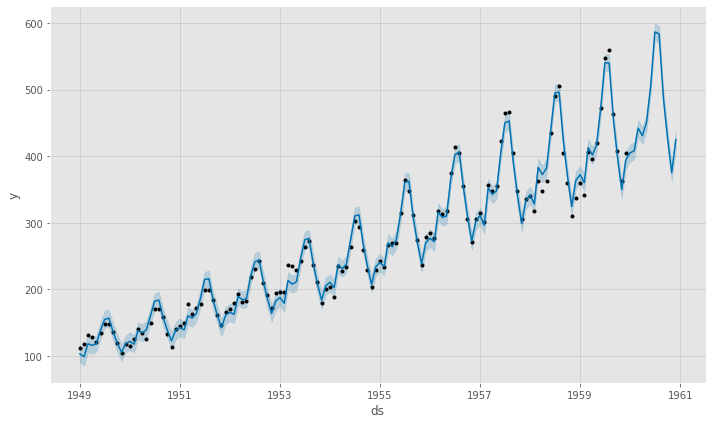

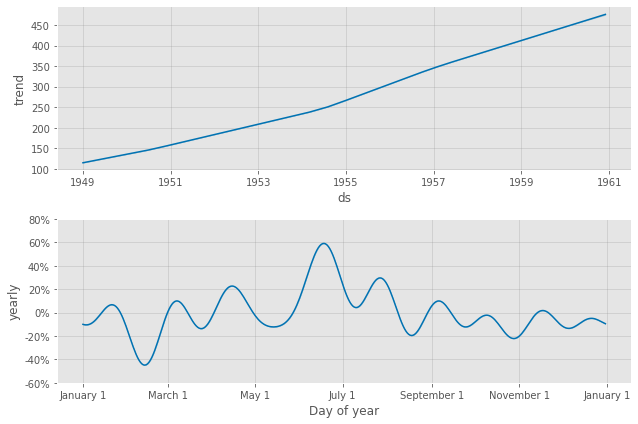

In [19]:
df2_pred_plot = df2_prophet_model.plot(df2_pred)
df2_pmpc = df2_prophet_model.plot_components(df2_pred)

In [20]:
df2_test['Prophet Predict'] = df2_pred.iloc[-test_length:].loc[:, 'yhat']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


RMSE:
23.586963759998113
MAE:
22.119700051395743
MAPE:
4.598615742485398


<AxesSubplot:title={'center':'Forecast evaluation'}>

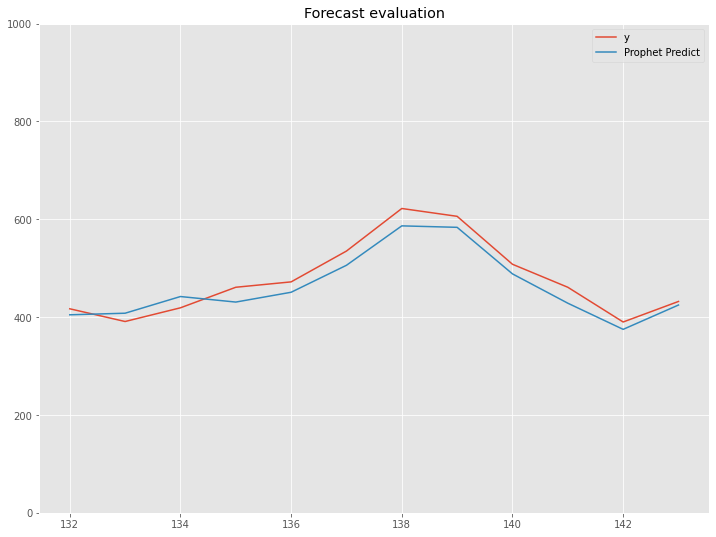

In [23]:
print('RMSE:')
print(np.sqrt(mean_squared_error(df2_test['y'], df2_test['Prophet Predict'])))
print('MAE:')
print(mean_absolute_error(df2_test['y'], df2_test['Prophet Predict'])) 
print('MAPE:')
print(mean(abs(df2_test['y'] - df2_test['Prophet Predict'])/df2_test['y']) *100)
df2_test.plot(title='Forecast evaluation',ylim=[0,1000])

In [24]:
# NeuralProphet Case

df2_neural_model = NeuralProphet(seasonality_mode='multiplicative')
df2_neural_model_res = df2_neural_model.fit(df2_train, freq='M')

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.config.init_data_params) - Setting normalization to global as only one dataframe provided for training.
INFO - (NP.utils.set_auto_seasonalities) - Disabling weekly seasonality. Run NeuralProphet with weekly_seasonality=True to override this.
INFO - (NP.utils.set_auto_seasonalities) - Disabling daily seasonality. Run NeuralProphet with daily_seasonality=True to override this.
INFO - (NP.config.set_auto_batch_epoch) - Auto-set batch_size to 16
INFO - (NP.config.set_auto_batch_epoch) - Auto-set epochs to 456


  0%|          | 0/109 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.78E-01, min: 3.16E-01


  0%|          | 0/109 [00:00<?, ?it/s]

INFO - (NP.utils_torch.lr_range_test) - lr-range-test results: steep: 1.47E-01, min: 3.16E-01
INFO - (NP.forecaster._init_train_loader) - lr-range-test selected learning rate: 1.38E-01
Epoch[456/456]: 100%|██████████| 456/456 [00:06<00:00, 69.06it/s, SmoothL1Loss=0.000316, MAE=7.03, RMSE=8.93, Loss=0.000241, RegLoss=0]


In [25]:
df2_n_future = df2_neural_model.make_future_dataframe(df2_train, periods=test_length, n_historic_predictions=len(df2_train))
df2_n_pred = df2_neural_model.predict(df2_n_future)

INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.909% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.972% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils._infer_frequency) - Major frequency MS corresponds to 90.972% of the data.
INFO - (NP.df_utils._infer_frequency) - Defined frequency is equal to major frequency - MS
INFO - (NP.df_utils.return_df_in_original_format) - Returning df with no ID column


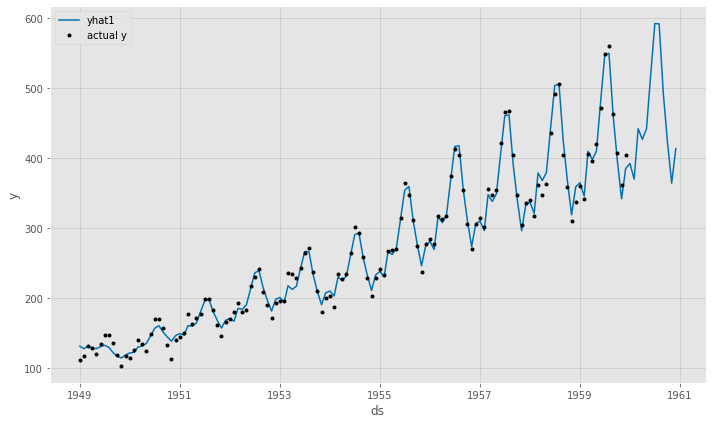

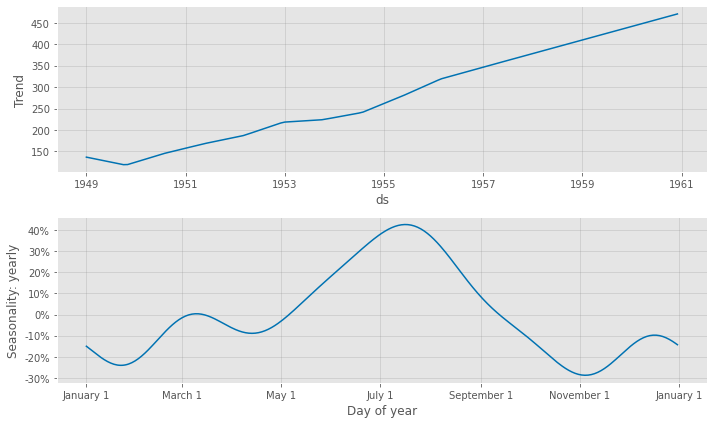

In [26]:
df2_pred_plot = df2_neural_model.plot(df2_n_pred)
df2_n_pmpc = df2_neural_model.plot_components(df2_n_pred)

In [30]:
df2_test['NeuralProphet Predict'] = df2_n_pred.iloc[-test_length:].loc[:, 'yhat1']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


MAE(Prophet):
22.119700051395743
MAE(NeuralProphet):
24.352630615234375
----------------------------
MAPE(Prophet):
4.598615742485398
MAPE(NeuralProphet):
5.262671829836602


<AxesSubplot:title={'center':'Forecast evaluation'}>

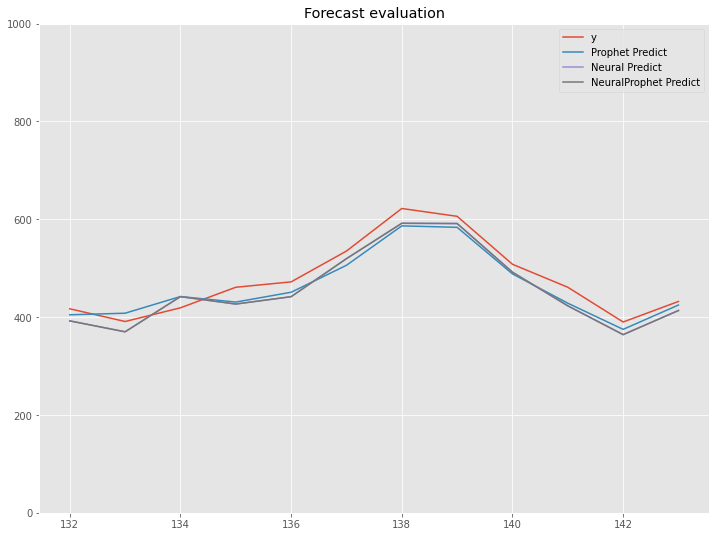

In [31]:
# Airline Passengers（飛行機乗客数）
# NeuralProphet 予測モデルの精度検証（テストデータ期間）
print('MAE(Prophet):')
print(mean_absolute_error(df2_test['y'], df2_test['Prophet Predict'])) 
print('MAE(NeuralProphet):')
print(mean_absolute_error(df2_test['y'], df2_test['NeuralProphet Predict'])) 
print('----------------------------')
print('MAPE(Prophet):')
print(mean(abs(df2_test['y'] - df2_test['Prophet Predict'])/df2_test['y']) *100)
print('MAPE(NeuralProphet):')
print(mean(abs(df2_test['y'] - df2_test['NeuralProphet Predict'])/df2_test['y']) *100)
df2_test.plot(title='Forecast evaluation',ylim=[0,1000])

In [35]:
def objective(trial):
    #ステップ2&3
    params = {'changepoint_prior_scale' : 
                 trial.suggest_float('changepoint_prior_scale',
                                       0.001,0.5
                                      ),
              'seasonality_prior_scale' : 
                 trial.suggest_float('seasonality_prior_scale',
                                       0.01,10
                                      ),
              'seasonality_mode' : 
                 trial.suggest_categorical('seasonality_mode',
                                           ['additive', 'multiplicative']
                                          )
             }
    m = Prophet(**params)
    #ステップ4
    m.fit(df2_train)
    df_future = m.make_future_dataframe(periods=test_length,freq='M')
    df_pred = m.predict(df_future) 
    preds = df_pred.tail(len(df2_test))
    val_rmse = np.sqrt(mean_squared_error(df2_test.y, preds.yhat))
    return val_rmse

In [36]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100, n_jobs=-1)
print(f"The best value is : \n {study.best_value}")
print(f"The best parameters are : \n {study.best_params}")

[I 2022-10-30 02:09:21,861] A new study created in memory with name: no-name-ed8f73c5-dcc4-4f6e-adab-dc4603779c1f
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  if __name__ == "__main__":
02:09:22 - cmdstanpy - INFO - Chain [1] start processing
02:09:22 - cmdstanpy - INFO - Chain [1] start processing
02:09:22 - cmdstanpy - INFO - Chain [1] start processing
02:09:22 - cmdstanpy - INFO - Chain [1] start processing
02:09:22 - cmdstanpy - INFO - Chain [1] done processing
02:09:22 

The best value is : 
 22.611566355044232
The best parameters are : 
 {'changepoint_prior_scale': 0.4982572241515925, 'seasonality_prior_scale': 3.788192472343346, 'seasonality_mode': 'multiplicative'}


In [37]:
m = Prophet(**study.best_params)
m.fit(df2_train)
# 予測の実施（学習期間＋テスト期間）
df_future = m.make_future_dataframe(periods=test_length,
                                    freq='M')
df_pred = m.predict(df_future) 

02:13:25 - cmdstanpy - INFO - Chain [1] start processing
02:13:26 - cmdstanpy - INFO - Chain [1] done processing


In [38]:
df2_test['ProphetOptuna Predict'] = df_pred.iloc[-test_length:].loc[:, 'yhat']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<AxesSubplot:title={'center':'Forecast evaluation'}>

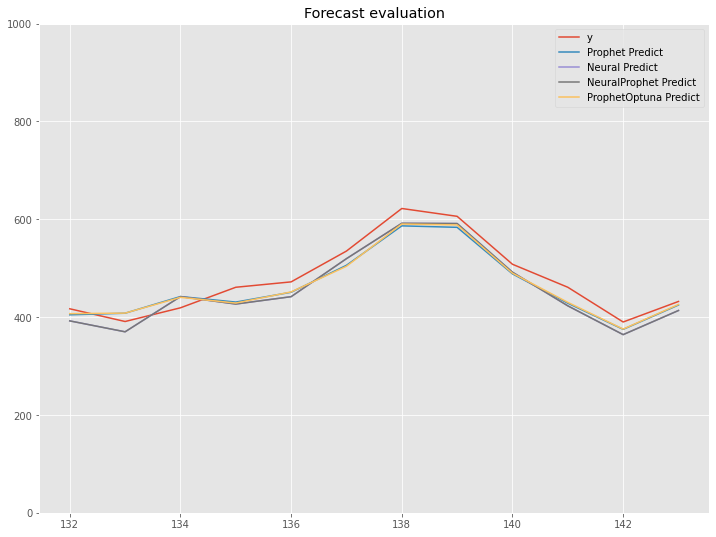

In [40]:
df2_test.plot(title='Forecast evaluation',ylim=[0,1000])

In [42]:
# NeuralProphet Optuna

---
---

# 以下、動作確認済み Prophet

---
---

In [ ]:
asd

In [79]:
# データ読み込み
url = 'https://www.salesanalytics.co.jp/591h'

In [80]:
df = pd.read_csv(url)
df.head(5)

,Month,Passengers
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


In [81]:
df.columns = ['ds', 'y'] # Plot用に読み出ししやすいようにColumnsを変換しておく

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ds      144 non-null    object
 1   y       144 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ KB


,ds,y
0,1949-01-01,112
1,1949-02-01,118
2,1949-03-01,132
3,1949-04-01,129
4,1949-05-01,121


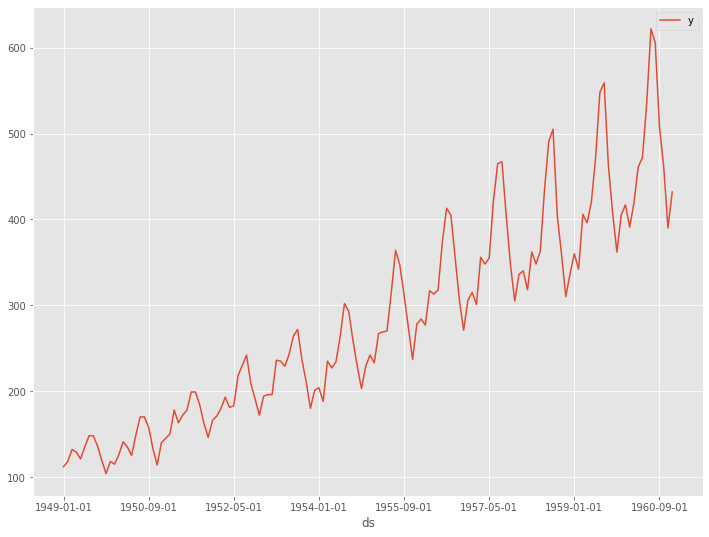

In [82]:
df.plot(kind='line', x='ds', y='y')
df.info()
df.head(5)

In [83]:
df.describe()

,y
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [84]:
df.memory_usage()

Index     128
ds       1152
y        1152
dtype: int64

In [85]:
# 【Q.】時系列データの無作為サンプリングは意味を持つか？ 
#　【A.】そもそも時系列をランダムサンプリングを行うと、NANデータが出来上がってしまうので意味がない

train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

In [86]:
test_length = int(len(df) * 0.2)  # 0.2サイズ
#test_length = 12
df_train = df.iloc[:-test_length]
df_test = df.iloc[-test_length:]

In [87]:
m = Prophet()
m.fit(df_train)

In [88]:
df_future = m.make_future_dataframe(periods=test_length, freq='M')
df_pred = m.predict(df_future)

In [89]:
df['Predict'] = df_pred['yhat']

In [90]:
preds = df.iloc[-test_length:].loc[:, 'Predict']
y = df.iloc[-test_length:].loc[:, 'y']

RMSE:
40.9774159580544
MAE:
34.18419553394252
MAPE(%):
8.0276244165037


<AxesSubplot:title={'center':'Forecast evaluation'}, xlabel='ds'>

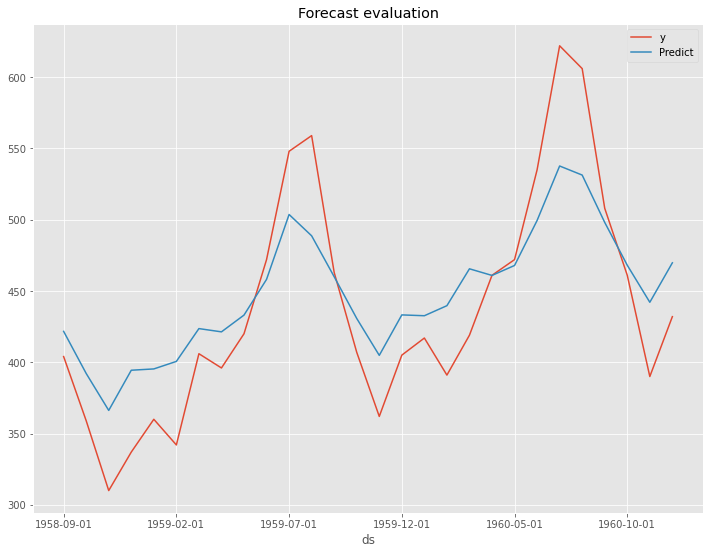

In [91]:
# 表示が元のデータと少し違うのは、元のデータは test_length は12だが、この場合0.2％を使用しているので出力のサイズが違う

print('RMSE:')
print(np.sqrt(mean_squared_error(y, preds)))
print('MAE:')
print(mean_absolute_error(y, preds)) 
print('MAPE(%):')
print(np.mean(abs(y - preds)/y)*100)
## グラフ化
df.iloc[-test_length:].plot(kind='line',
                            x='ds',
                            title='Forecast evaluation'
                           )

↑

==============================================================================================

In [37]:
def objective(trial):
    params = {'changepoint_prior_scale' : 
                 trial.suggest_uniform('changepoint_prior_scale',
                                       0.001,0.5
                                      ),
              'seasonality_prior_scale' : 
                 trial.suggest_uniform('seasonality_prior_scale',
                                       0.01,10
                                      ),
              'seasonality_mode' : 
                 trial.suggest_categorical('seasonality_mode',
                                           ['additive', 'multiplicative'] # additive 加法モデル、　multiplicative 乗法モデル
                                          )
             }
    m = Prophet(**params)
    m.fit(df_train)
    
    # デフォルトでは、最初の学習期間は地平線の3倍に設定、カットオフは予測範囲の半分ごとに行われる
    # 最初のカットオフで730日間のトレーニングデータから開始し、180日ごとに予測を行い、365日間の範囲で予測パフォーマンスを評価するために相互検証を行う。
    df_cv = cross_validation(m,
                             initial='730 days', # 初期トレーニング期間
                             period='180 days', # 初期トレーニング期間のサイズとカットオフ日の間隔を指定
                             horizon = '365 days', # 予測範囲
                             parallel="processes") # 並列モードで実行
    df_p = performance_metrics(df_cv)
    
    return df_p['rmse'].values[0]

In [71]:
study = optuna.create_study(direction='minimize')

[I 2022-10-28 12:13:52,706] A new study created in memory with name: no-name-d73dedd5-cb9f-4f8d-a022-5b1d7c0c3979


In [41]:
#study.optimize(objective, n_traials=100) < n_traials の所が n_traialsになっているので動かない
study.optimize(objective, n_trials=10, n_jobs=2)
#study.optimize(objective)

# 最適パラメータ出力
print(f'The best value is : \n {study.best_value}')
print(f'The best parameters are : \n {study.best_params}')

[I 2022-10-28 12:03:58,014] Trial 0 finished with value: 13.350890248656134 and parameters: {'changepoint_prior_scale': 0.43809891662162603, 'seasonality_prior_scale': 1.979433530781218, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 13.350890248656134.
[I 2022-10-28 12:03:58,051] Trial 1 finished with value: 14.285718704202855 and parameters: {'changepoint_prior_scale': 0.4399482146755566, 'seasonality_prior_scale': 9.02651983745418, 'seasonality_mode': 'multiplicative'}. Best is trial 0 with value: 13.350890248656134.
[I 2022-10-28 12:04:49,962] Trial 3 finished with value: 7.4647975099760355 and parameters: {'changepoint_prior_scale': 0.10174427082502184, 'seasonality_prior_scale': 3.7582476080631873, 'seasonality_mode': 'additive'}. Best is trial 3 with value: 7.4647975099760355.
[I 2022-10-28 12:05:06,655] Trial 2 finished with value: 15.325873967411189 and parameters: {'changepoint_prior_scale': 0.3862830382293387, 'seasonality_prior_scale': 9.258522032527447, 'seas

The best value is : 
 7.256500533586324
The best parameters are : 
 {'changepoint_prior_scale': 0.1561088824180854, 'seasonality_prior_scale': 3.276134751696555, 'seasonality_mode': 'additive'}


In [42]:
# 交差検証によって取得した結果を元に　Optunaで算出した最適パラメータを使って予測モデルを構築する

# 最適パラメータで予測モデル構築
m = Prophet(**study.best_params)
m.fit(df_train)

In [43]:
# 予測の実施
df_future = m.make_future_dataframe(periods=test_length, freq='M')
df_pred = m.predict(df_future)

In [44]:
df['Predict'] = df_pred['yhat']

RMSE:
41.95336289512278
MAE:
35.33273261314304
MAPE(%):
8.355564248253863


<AxesSubplot:title={'center':'Forecast evaluation'}, xlabel='ds'>

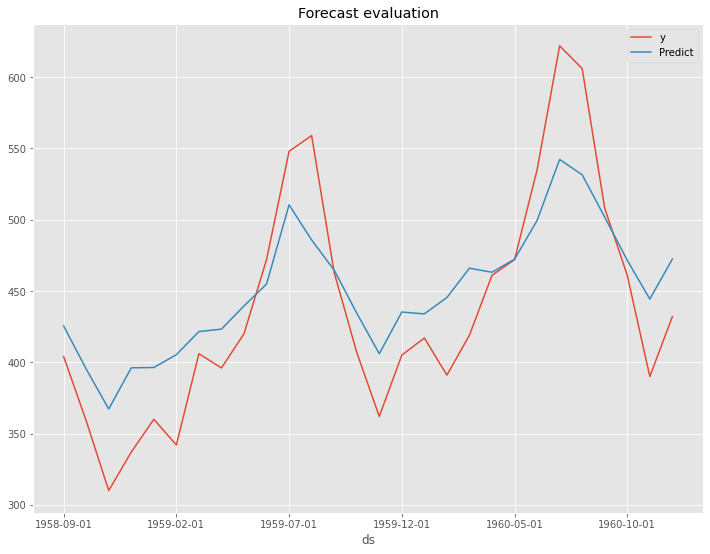

In [45]:
preds = df.iloc[-test_length:].loc[:, 'Predict']
y = df.iloc[-test_length:].loc[:, 'y']

print('RMSE:')
print(np.sqrt(mean_squared_error(y, preds)))
print('MAE:')
print(mean_absolute_error(y, preds)) 
print('MAPE(%):')
print(np.mean(abs(y - preds)/y)*100)
## グラフ化
df.iloc[-test_length:].plot(kind='line',
                            x='ds',
                            title='Forecast evaluation'
                           )

In [96]:
# CVを使用せずに目的関数の最小化を試みる
# 目的関数の設定（ステップ1）

def objective(trial):
    
    #ステップ2&3
    params = {'changepoint_prior_scale' : 
                 trial.suggest_uniform('changepoint_prior_scale',
                                       0.001,0.5
                                      ),
              'seasonality_prior_scale' : 
                 trial.suggest_uniform('seasonality_prior_scale',
                                       0.01,10
                                      ),
              'holidays_prior_scale' :
                 trial.suggest_uniform('holidays_prior_scale',
                                      0.01,10
                                      ),
              'seasonality_mode' : 
                 trial.suggest_categorical('seasonality_mode',
                                           ['additive', 'multiplicative']
                                          )
             }
    m = Prophet(**params)
    
    #ステップ4
    m.fit(df_train)
    df_future = m.make_future_dataframe(periods=test_length,freq='M')
    df_pred = m.predict(df_future) 
    preds = df_pred.tail(len(df_test))
    val_rmse = np.sqrt(mean_squared_error(df_test.y, preds.yhat))
    return val_rmse

In [98]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=200, n_jobs=-1)
# 最適パラメータの出力
print(f"The best value is : \n {study.best_value}")
print(f"The best parameters are : \n {study.best_params}")

[I 2022-10-28 12:54:57,518] A new study created in memory with name: no-name-a089fb3b-1b37-4a42-87a9-c48a6d72899c
[I 2022-10-28 12:55:00,753] Trial 2 finished with value: 23.634841265673703 and parameters: {'changepoint_prior_scale': 0.0941906223686537, 'seasonality_prior_scale': 2.5820560837022644, 'holidays_prior_scale': 1.1793225684470312, 'seasonality_mode': 'multiplicative'}. Best is trial 2 with value: 23.634841265673703.
[I 2022-10-28 12:55:00,788] Trial 1 finished with value: 25.98809538791993 and parameters: {'changepoint_prior_scale': 0.44566114109705623, 'seasonality_prior_scale': 7.813426546024386, 'holidays_prior_scale': 7.746909263049707, 'seasonality_mode': 'multiplicative'}. Best is trial 2 with value: 23.634841265673703.
[I 2022-10-28 12:55:00,801] Trial 3 finished with value: 26.025083124064185 and parameters: {'changepoint_prior_scale': 0.38501806396153926, 'seasonality_prior_scale': 8.8101004827508, 'holidays_prior_scale': 7.526679909738985, 'seasonality_mode': 'mul

The best value is : 
 18.002617359536085
The best parameters are : 
 {'changepoint_prior_scale': 0.012767861590760446, 'seasonality_prior_scale': 3.165439921076809, 'holidays_prior_scale': 6.8245305211259435, 'seasonality_mode': 'multiplicative'}


RMSE:
18.002617359536085
MAE:
14.199909264620198
MAPE(%):
3.3578661321445726


<AxesSubplot:title={'center':'Forecast evaluation'}, xlabel='ds'>

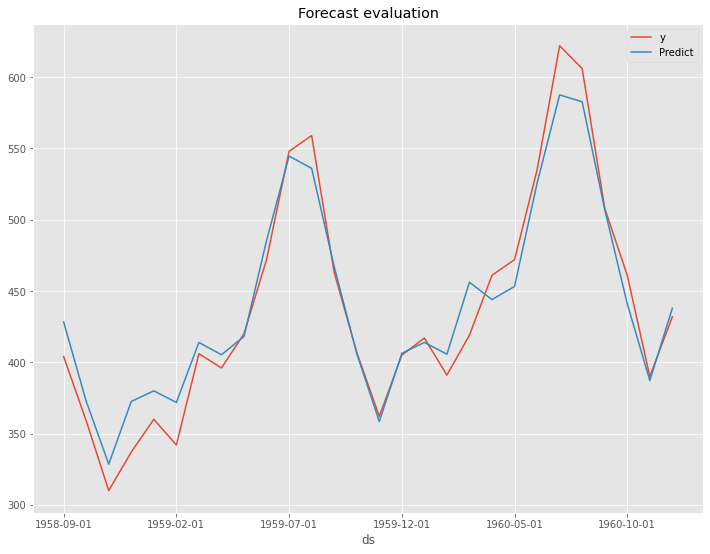

In [99]:
# 最適パラメータで予測モデル構築
m = Prophet(**study.best_params)
m.fit(df_train)
# 予測の実施（学習期間＋テスト期間）
df_future = m.make_future_dataframe(periods=test_length,
                                    freq='M')
df_pred = m.predict(df_future) 

# 元のデータセットに予測値を結合
df['Predict'] = df_pred['yhat']
# 予測精度（テストデータ期間）
## 予測値と実測値
preds = df.iloc[-test_length:].loc[:, 'Predict']
y = df.iloc[-test_length:].loc[:, 'y']
## 指標出力
print('RMSE:')
print(np.sqrt(mean_squared_error(y, preds)))
print('MAE:')
print(mean_absolute_error(y, preds)) 
print('MAPE(%):')
print(np.mean(abs(y - preds)/y)*100)
## グラフ化
df.iloc[-test_length:].plot(kind='line',
                            x='ds',
                            title='Forecast evaluation'
                           )

---
ここで、結果を見ると、
以下が、テストデータの精度評価指標の値の変化

RMSE: 41.57 → 19.68

MAE: 34.02 → 17.39

MAPE(%): 6.78% → 3.60%

となるはずだが、より精度の高い

RMSE:
18.035438896420267

MAE:
14.18132314452087

MAPE(%):
3.351298132264165

という結果が出た、これは、どのような変化によるものか？テストセットの分割を通常の分割よりも0.2％にしている。

---

この結果から、CVを実行する際のProphetのパラメータの設定を適切に指定しなければ最適な結果は得られないという事でもある。
CVの訓練方法を変更する必要がある。

---

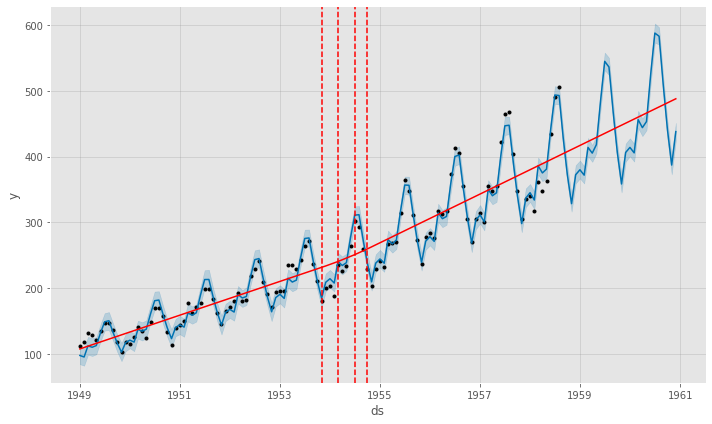

In [100]:
from prophet.plot import add_changepoints_to_plot

fig_air = m.plot(df_pred)
a = add_changepoints_to_plot(fig_air.gca(), m, df_pred)

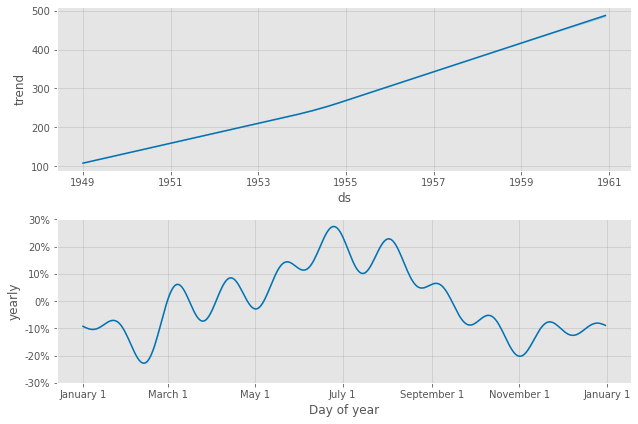

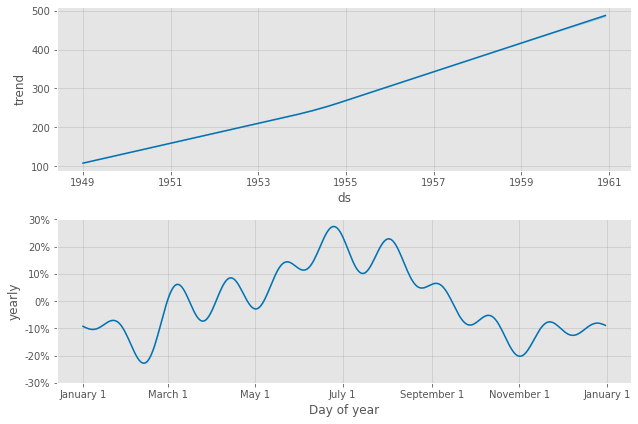

In [101]:
m.plot_components(df_pred)

---
---

オーストラリアのワイン販売量

【注意】単位が高すぎるので０～１の正規化か標準化を行う方がRMSEの判断をしやすいのではないかと思う。

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ds      176 non-null    object
 1   y       176 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.9+ KB


,ds,y
0,Jan-80,15136
1,Feb-80,16733
2,Mar-80,20016
3,Apr-80,17708
4,May-80,18019


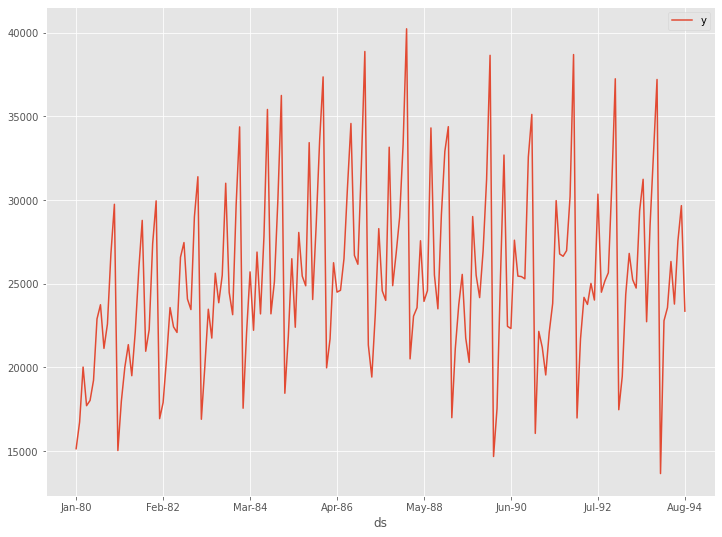

In [49]:
url = 'https://www.salesanalytics.co.jp/l6p7'
df = pd.read_csv(url)
df.columns = ['ds', 'y']
# データ確認
df.plot(kind='line',x='ds', y='y')
df.info() #変数の情報
df.head() #データの一部

In [50]:
test_length = 12
df_train = df.iloc[:-test_length]
df_test = df.iloc[-test_length:]

RMSE:
2923.7450006704994
MAE:
2572.5920740528145
MAPE(%):
11.114336412306224


<AxesSubplot:title={'center':'Forecast evaluation'}, xlabel='ds'>

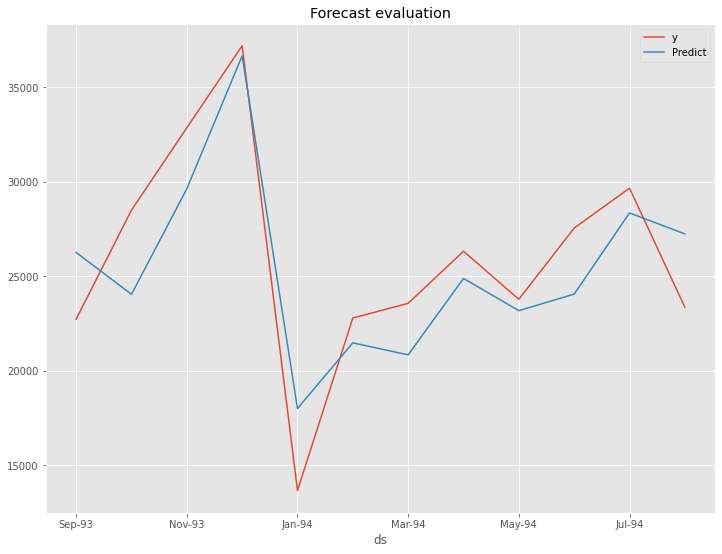

In [51]:
# 予測モデル構築
m = Prophet()
m.fit(df_train)
# 予測の実施（学習期間＋テスト期間）
df_future = m.make_future_dataframe(periods=test_length,
                                    freq='M')
df_pred = m.predict(df_future) 
# 元のデータセットに予測値を結合
df['Predict'] = df_pred['yhat']
# 予測精度（テストデータ期間）
## 予測値と実測値
preds = df.iloc[-test_length:].loc[:, 'Predict']
y = df.iloc[-test_length:].loc[:, 'y']
## 指標出力
print('RMSE:')
print(np.sqrt(mean_squared_error(y, preds)))
print('MAE:')
print(mean_absolute_error(y, preds)) 
print('MAPE(%):')
print(np.mean(abs(y - preds)/y)*100)
## グラフ化
df.iloc[-test_length:].plot(kind='line',
                            x='ds',
                            title='Forecast evaluation'
                           )

In [52]:
# 目的関数の設定（ステップ1）
def objective(trial):
    #ステップ2&3
    params = {'changepoint_prior_scale' : 
                 trial.suggest_uniform('changepoint_prior_scale',
                                       0.001,0.5
                                      ),
              'seasonality_prior_scale' : 
                 trial.suggest_uniform('seasonality_prior_scale',
                                       0.01,10
                                      ),
              'seasonality_mode' : 
                 trial.suggest_categorical('seasonality_mode',
                                           ['additive', 'multiplicative']
                                          )
             }
    m = Prophet(**params)
    #ステップ4
    m.fit(df_train)
    df_future = m.make_future_dataframe(periods=test_length,freq='M')
    df_pred = m.predict(df_future) 
    preds = df_pred.tail(len(df_test))
    val_rmse = np.sqrt(mean_squared_error(df_test.y, preds.yhat))
    return val_rmse
# 目的関数の最適化を実行する（ステップ5）
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)
# 最適パラメータの出力
print(f"The best value is : \n {study.best_value}")
print(f"The best parameters are : \n {study.best_params}")

[I 2022-10-28 12:08:58,330] A new study created in memory with name: no-name-1c58d13d-124d-4f99-a16e-d196edcc0fc2
[I 2022-10-28 12:08:59,307] Trial 0 finished with value: 2849.3839822819987 and parameters: {'changepoint_prior_scale': 0.24469915426500333, 'seasonality_prior_scale': 6.9023140930805384, 'seasonality_mode': 'additive'}. Best is trial 0 with value: 2849.3839822819987.
[I 2022-10-28 12:08:59,910] Trial 1 finished with value: 5414.368236944114 and parameters: {'changepoint_prior_scale': 0.0017686302431962854, 'seasonality_prior_scale': 7.92937028468555, 'seasonality_mode': 'multiplicative'}. Best is trial 0 with value: 2849.3839822819987.
[I 2022-10-28 12:09:00,530] Trial 2 finished with value: 2865.5470234112463 and parameters: {'changepoint_prior_scale': 0.4388036502765471, 'seasonality_prior_scale': 5.081515770836745, 'seasonality_mode': 'multiplicative'}. Best is trial 0 with value: 2849.3839822819987.
[I 2022-10-28 12:09:01,170] Trial 3 finished with value: 2847.52938743

The best value is : 
 2519.008208879666
The best parameters are : 
 {'changepoint_prior_scale': 0.01696172847356294, 'seasonality_prior_scale': 7.465889119009134, 'seasonality_mode': 'multiplicative'}


RMSE:
2519.008208879666
MAE:
1991.5518712027533
MAPE(%):
8.975061463305527


<AxesSubplot:title={'center':'Forecast evaluation'}, xlabel='ds'>

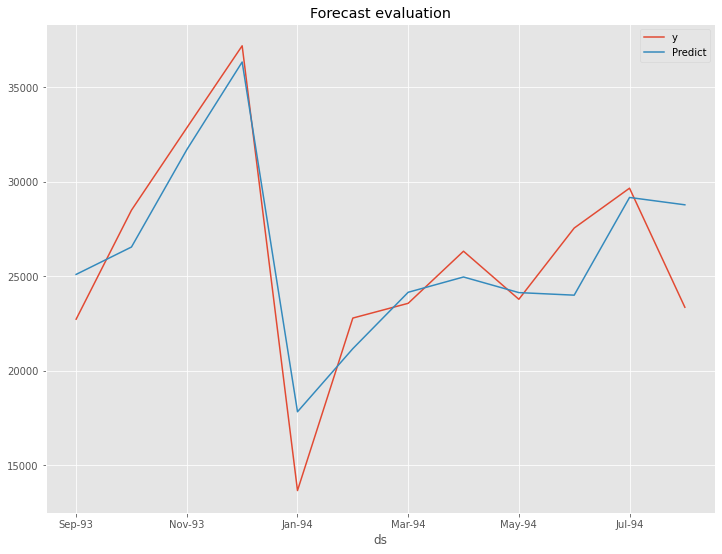

In [53]:
# 最適パラメータで予測モデル構築
m = Prophet(**study.best_params)
m.fit(df_train)
# 予測の実施（学習期間＋テスト期間）
df_future = m.make_future_dataframe(periods=test_length,
                                    freq='M')
df_pred = m.predict(df_future) 
# 元のデータセットに予測値を結合
df['Predict'] = df_pred['yhat']
# 予測精度（テストデータ期間）
## 予測値と実測値
preds = df.iloc[-test_length:].loc[:, 'Predict']
y = df.iloc[-test_length:].loc[:, 'y']
## 指標出力
print('RMSE:')
print(np.sqrt(mean_squared_error(y, preds)))
print('MAE:')
print(mean_absolute_error(y, preds)) 
print('MAPE(%):')
print(np.mean(abs(y - preds)/y)*100)
## グラフ化
df.iloc[-test_length:].plot(kind='line',
                            x='ds',
                            title='Forecast evaluation'
                           )

当然ですが、Optunaでハイパーパラメータチューニングして構築したProphetモデルを構築した方が、予測精度が高くなりました。

今回、Optunaでチューニングしたハイパーパラメータは3つでしたが、Prophetのハイパーパラメータはもう少し多いです。